# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Neel Mallik
- Joshua Herren
- Kunal Lotun
- Kyle Hong

In [2]:
# imports for base
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# imports for ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [3]:
#This whole block of code gets the raw data. 
# Site
url = "https://api.rawg.io/api/games"
# API key used to pull data
key = "07dfd979a676418e813cbba97a9dfe4f"
pages = 5
# (1) we'll need something like this since this API limits to the first page in a single get request

# Dictionary of parameters that is sent to the url in a get (r)
params = {
    "key": key,
    "dates": "2024-01-01,2025-12-31",  # filter by date released
    "ordering": "-added",  # sort by added (so we don't get random games with no adds)
    "page": pages
}

# send the get, get the json response, which we can't use directly, so convert it to a dictionary
data = requests.get(url, params=params).json()

# create empty list, we will store all of our data here
games = []
for pages in range(1, pages + 1): #Iterates through each page
    params = {
        "key": key,
        "dates": "2024-01-01,2025-12-31",  # filter by date released
        "ordering": "-added",  # sort by added (so we don't get random games with no adds)
        "page": pages #the current page
    }

    # send the get, get the json response, which we can't use directly, so convert it to a dictionary
    data = requests.get(url, params=params).json()

    for game in data.get("results", []):
        temp = game.get('added_by_status')
        games.append({  # append column with corresponding data (via get("{name of column needed}"))
            "name": game.get("name"),
            # for example, we create the column "name" with data from game (the specific game in "results", which is the actual data from the API, which is, in this case, the name of the game)
            "released": game.get("released"),
            "rating (out of 5.0)": game.get("rating"),
            "ratings_count": game.get("ratings_count"),
            "length (h)": game.get("playtime"),
            "added": game.get("added"),
            #"added_by_status": game.get("added_by_status"),
            "yet to be downloaded": temp.get('yet', 0),
            "owned": temp.get('owned', 0),
            "beaten": temp.get('beaten', 0),
            "have not played yet": temp.get('toplay', 0),
            "dropped": temp.get('dropped', 0),
            "currently playing": temp.get('playing', 0),
            "genres": [genre["name"] for genre in game.get("genres", [])]
            # in this line, we create the column "genres". this is a list of genres (as strings) so we iterate through the list and add    each one to the dataset

        })
# (2) we'll need to create another loop here that iterates however many times "pages" is set to, making sure to create a get request every time it iterates through a single page

# iterate through this until we reach each game
# convert to dataframe, i know this wasn't necessary but it just looked better this way similar to the spotify example
df = pd.DataFrame(games)
# display as a table rather than just text
display(df)

,name,released,rating (out of 5.0),ratings_count,length (h),added,yet to be downloaded,owned,beaten,have not played yet,dropped,currently playing,genres
0,Satisfactory,2024-09-11,4.29,332,12,2894,98,2225,104,147,208,112,"[Indie, Strategy, Adventure, Action]"
1,Vampire: The Masquerade – Bloodlines 2,2025-10-21,3.86,330,329,2428,286,689,28,1370,17,38,"[Action, RPG]"
2,S.T.A.L.K.E.R. 2: Heart of Chornobyl,2024-11-20,3.77,296,7,2150,334,533,106,1067,63,47,"[Shooter, Adventure, Action, RPG]"
3,V Rising,2024-05-08,3.72,169,7,2076,92,1591,71,141,149,32,"[Massively Multiplayer, Adventure, Action]"
4,Hollow Knight: Silksong,2025-09-04,4.29,178,24,1459,174,277,93,823,28,64,"[Indie, Platformer, Adventure, Action]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ANOMALOUS COFFEE MACHINE,2024-08-11,4.08,94,5,266,20,166,3,47,5,25,"[Indie, Simulation]"
96,Rise of the Ronin,2024-03-22,3.33,29,1,263,40,56,23,121,17,6,"[Adventure, Action, RPG]"
97,Still Wakes the Deep,2024-06-18,3.88,85,6,261,22,45,103,67,19,5,"[Adventure, Action]"
98,Silent Hill f,2025-09-24,3.64,58,36,261,32,31,63,108,16,11,"[Adventure, Action]"


In [4]:
# cleaning dataset function
def clean_data(df): 
    """
    Cleans the dataframe by doing the following:
        - Converting times to DateTime
        - Dropping duplicate games
        - Removing invalid rows
        - Showing current player ratio 
        - Turning genres into a string 
        - Adding a popularity score, rentention ratio, and engagement col
        - Removing games that do not meet rating count
        - Adds a Game Number
    
    Args: 
        df (pd.DataFrame) : a data frame to clean

    Returns:
        df (pd.DataFrame) : cleaned data frame
    """

    df = df.drop_duplicates(subset=['name']) # Remove Duplicates
    df = df.dropna(subset=['name', 'rating (out of 5.0)', 'ratings_count', 'added']) # Remove NA rows (rows without names, ratings, rating count, added or not)
    df['released'] = pd.to_datetime(df['released'], errors='coerce') # Converts released to datetime 

    # CLEANING GENRES INTO DUMMY BOOL COLUMNS | https://pandas.pydata.org/docs/reference/api/pandas.Series.str.get_dummies.html | Completely forgot how to use this but I used this StackOverflow article: https://stackoverflow.com/questions/18889588/create-dummies-from-column-with-multiple-values-in-pandas
    genre_dummies = df['genres'].str.join(', ').str.get_dummies(sep=', ').astype(bool) # create boolean columns for each unique genre found in the dataset, separated by ','. For example, "(RPG, Strategy,..)"
    df = df.drop('genres', axis=1).join(genre_dummies) # remove the original genres column and add the new boolean genre columns
    # must clear output and remake the original data (execute above cell) then run this one in order to rerun

    df['active rate'] = (df['currently playing'] / (df['owned'] + 1)).round(3) # Adds the current player ratio
    df['popularity score'] = (df['added'] + df['owned'] + df['currently playing']).round(3) # Adds a pop score, calculated by adding the amount added, owned, and currently playing
    df['retention ratio'] = ((df['currently playing'] + df['beaten']) / (df['dropped'] + 1)).round(3) # Adds a retention score, how well people who bought the game are still playing it
    df['engagement'] = ((df['currently playing'] + df['beaten']) / (df['added'] + 1)).round(3) # Fraction of interested users who actually played or completed the game
    df = df[df['ratings_count'] > 10] # Remove games that have less than 10 ratings
    df.index.name = "Game Number"
    
    return df 

df = clean_data(df)
display(df)

,name,released,rating (out of 5.0),ratings_count,length (h),added,yet to be downloaded,owned,beaten,have not played yet,...,RPG,Racing,Shooter,Simulation,Sports,Strategy,active rate,popularity score,retention ratio,engagement
Game Number,,,,,,,,,,,,,,,,,,,,,
0,Satisfactory,2024-09-11,4.29,332,12,2894,98,2225,104,147,...,False,False,False,False,False,True,0.050,5231,1.033,0.075
1,Vampire: The Masquerade – Bloodlines 2,2025-10-21,3.86,330,329,2428,286,689,28,1370,...,True,False,False,False,False,False,0.055,3155,3.667,0.027
2,S.T.A.L.K.E.R. 2: Heart of Chornobyl,2024-11-20,3.77,296,7,2150,334,533,106,1067,...,True,False,True,False,False,False,0.088,2730,2.391,0.071
3,V Rising,2024-05-08,3.72,169,7,2076,92,1591,71,141,...,False,False,False,False,False,False,0.020,3699,0.687,0.050
4,Hollow Knight: Silksong,2025-09-04,4.29,178,24,1459,174,277,93,823,...,False,False,False,False,False,False,0.230,1800,5.414,0.108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ANOMALOUS COFFEE MACHINE,2024-08-11,4.08,94,5,266,20,166,3,47,...,False,False,False,True,False,False,0.150,457,4.667,0.105
96,Rise of the Ronin,2024-03-22,3.33,29,1,263,40,56,23,121,...,True,False,False,False,False,False,0.105,325,1.611,0.110
97,Still Wakes the Deep,2024-06-18,3.88,85,6,261,22,45,103,67,...,False,False,False,False,False,False,0.109,311,5.400,0.412


## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [5]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [6]:
def line_of_best_fit(oldx, y):
    """
    Args:
        X (array): the x pos of the points (1-d) 
        Y (array): the y pos of the points (1-d)
    
    Returns:
        XY (array): The line of best fit
    """
    X = add_bias_column(oldx)
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

In [7]:
def linreg_predict(Xnew, ynew, m):
    """
    Args:
        Xnew: an array, either 1-d or 2-d which includes all the P predictor features, not including bias term
        ynew: a 1-d array which includes all corresponding response values to `Xnew`
        m: a 1-d array of length $p+1$ which contains the coefficients from the `line_of_best_fit` function

    Returns:
        rval (Dict):
            'ypreds': the predicted values from applying `m` to `Xnew`
            'resids': the residuals, the differences between `ynew` and `ypreds`
            'mse': the mean squared error
            'r2': the coefficient of determination ($R^2$) representing the proportion of variability in `ynew` explained by the line of best fit
    """
    rval = {}
    rval['ypreds'] = ypreds(Xnew, m)
    rval['resids'] = resids(ynew, rval['ypreds'])
    rval['mse'] = mse(rval['resids'])
    rval['r2'] = r2(rval['mse'], ynew)
    return rval

def ypreds(Xnew, m):
    Xb = add_bias_column(Xnew)  
    return Xb.dot(m)            

def resids(ynew, ypreds):
    return np.subtract(ynew, ypreds)

def mse(resids):
    return (resids**2).mean()

def r2(mse, y):
    return 1 - (mse/y.var())

## Attempt 1 - Linear Regression

Model 1
engagement to rating (out of 5.0)
MSE: 0.2591
R2: 0.3176


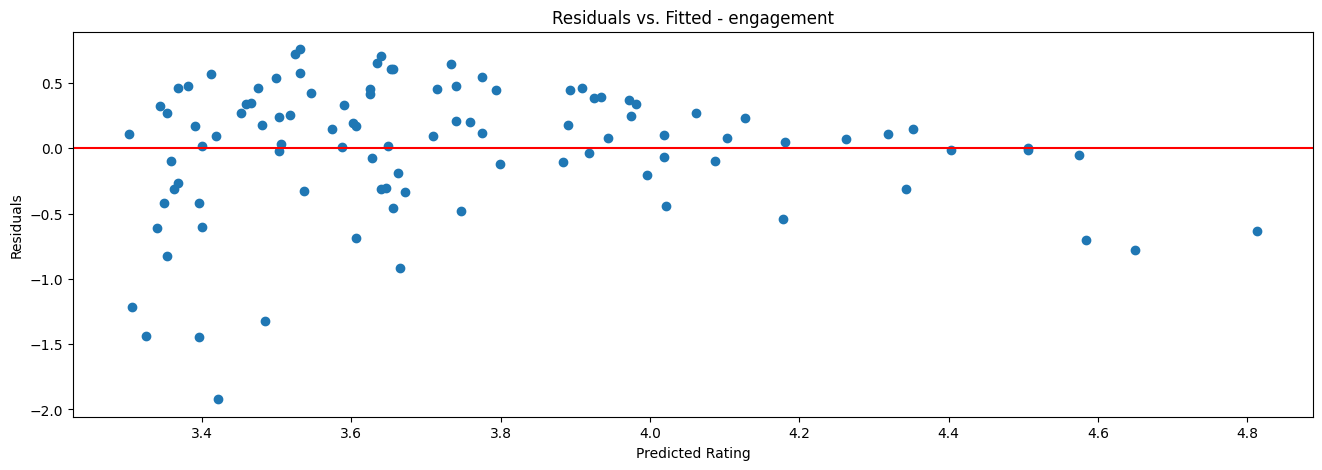

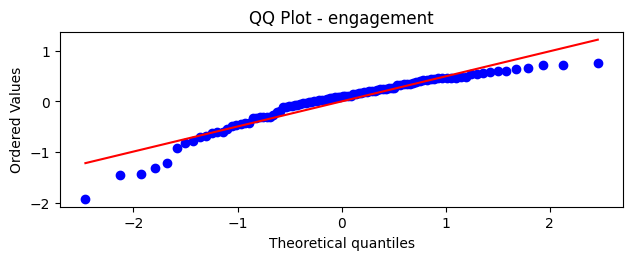

Model 2
retention ratio to rating (out of 5.0)
MSE: 0.2980
R2: 0.2151


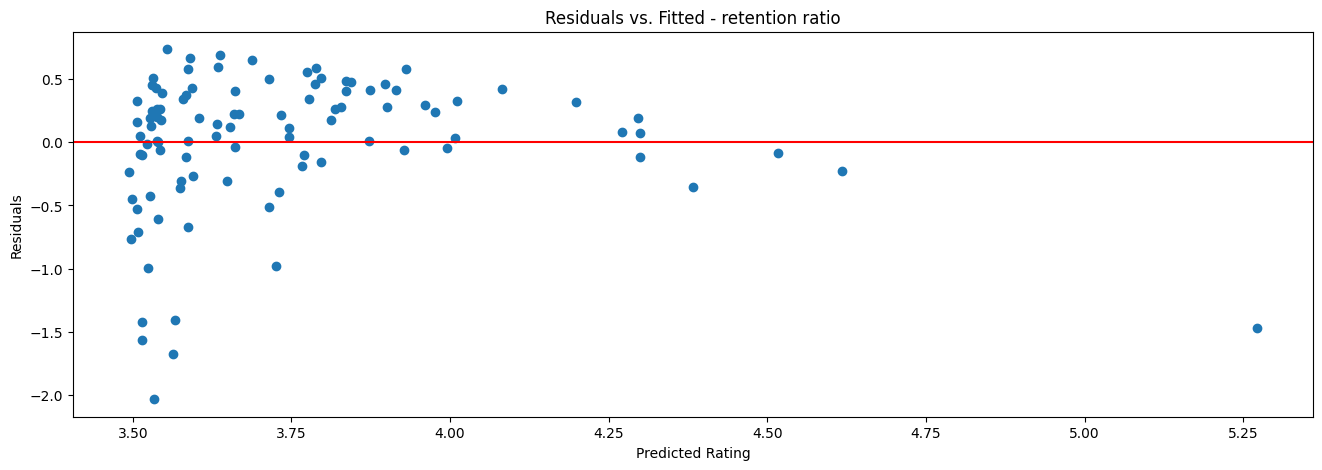

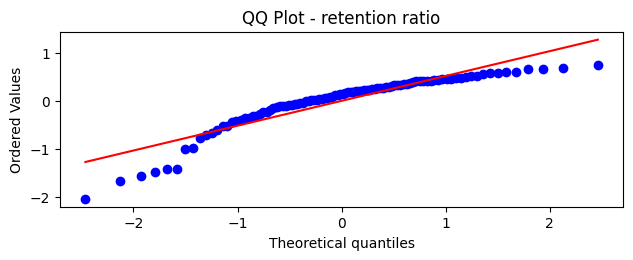

Model 3
active rate to rating (out of 5.0)
MSE: 0.3022
R2: 0.2041


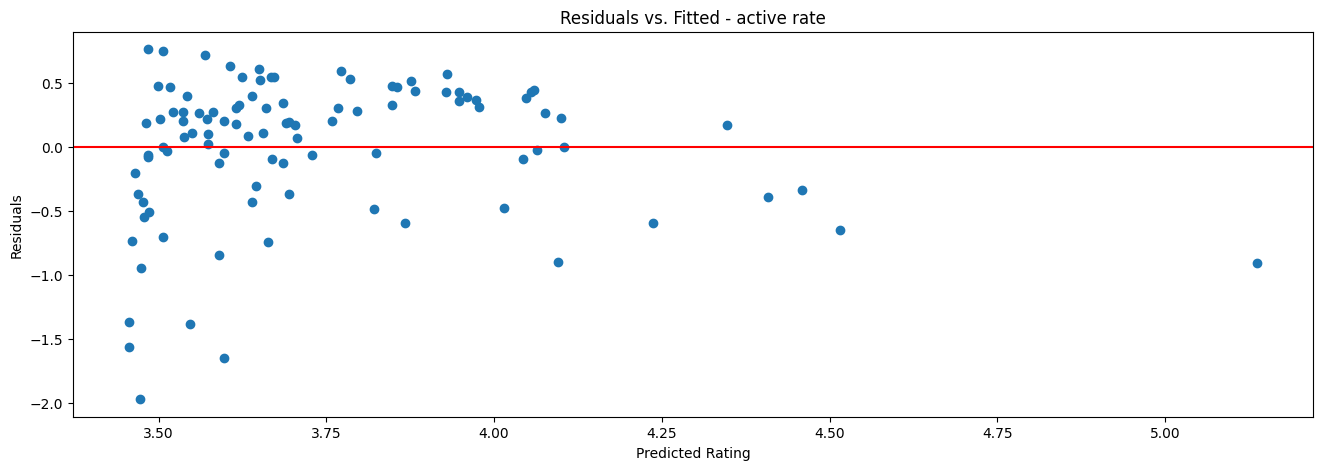

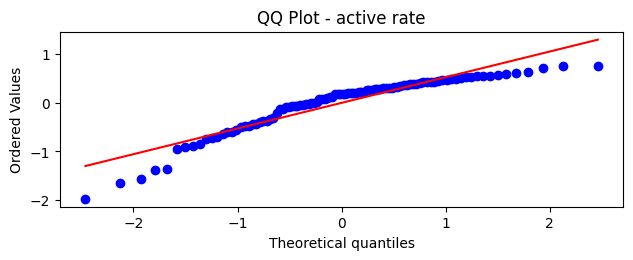

In [8]:
def linear_model(df, feature_name, target='rating (out of 5.0)'):
    '''
    Args: 
        ...
    Returns: 
        ...

    Need to make some docstring at some point
    '''
    X = df[feature_name].values
    y = df[target].values
    
    m = line_of_best_fit(X, y)
    
    results = linreg_predict(X, y, m)
    
    residuals = results['resids']
    
    print(f"{feature_name} to {target}")
    print(f"MSE: {results['mse']:.4f}")
    print(f"R2: {results['r2']:.4f}")
    
    plt.figure(figsize=(16, 5))
    plt.scatter(results['ypreds'], results['resids'])
    plt.axhline(0, color='red')
    plt.xlabel("Predicted Rating")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs. Fitted - {feature_name}")

    plt.figure(figsize=(16,5))
    plt.subplot(2, 2, 3) 
    probplot(residuals, dist="norm", plot=plt) 
    plt.title(f'QQ Plot - {feature_name}')

    plt.show()

print("Model 1")
linear_model(df, 'engagement')
print("Model 2")
linear_model(df, 'retention ratio')
print("Model 3")
linear_model(df, 'active rate')


## Attempt 2: Polynomial Regression

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import probplot

def poly_model(df, feature_name):
    """
        Args:
            ...
        Return:
            ... 
            Also need to make docstring dw
    """
    degree = 4
    target = 'rating (out of 5.0)'
    X = np.array(df[feature_name]).reshape(-1, 1)
    y = df[target].values
    poly = PolynomialFeatures(degree=degree)
    X_poly_bias = poly.fit_transform(X)
    X_poly = X_poly_bias[:, 1:]
    m = line_of_best_fit(X_poly, y)
    results = linreg_predict(X_poly, y, m)

    print(f"\nPolynomial Model (degree {degree}) for {feature_name} to {target}")
    print(f"MSE: {results['mse']:.4f}")
    print(f"R2:  {results['r2']:.4f}")

def poly_crossval(df, feature_name):
    """
        Same thing docstring needs to be done
    """
    target = 'rating (out of 5.0)'
    degree = 4
    X = np.array(df[feature_name]).reshape(-1, 1)
    y = df[target].values 
    
    poly = PolynomialFeatures(degree=degree)
    X_poly_bias = poly.fit_transform(X)
    X_poly = X_poly_bias[:, 1:]  
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_poly, y, test_size=0.3, random_state=3)

    m = line_of_best_fit(Xtrain, ytrain)
    results = linreg_predict(Xtest, ytest, m)
    
    print(f"\nCross-Validation for {feature_name} (degree {degree})")
    print(f"MSE: {results['mse']:.4f}")
    print(f"R2:  {results['r2']:.4f}")

poly_model(df, "engagement")
poly_model(df, "retention ratio")
poly_model(df, "active rate")

poly_crossval(df, "engagement")
poly_crossval(df, "retention ratio")
poly_crossval(df, "active rate")


Polynomial Model (degree 4) for engagement to rating (out of 5.0)
MSE: 0.2153
R2:  0.4329

Polynomial Model (degree 4) for retention ratio to rating (out of 5.0)
MSE: 0.2356
R2:  0.3794

Polynomial Model (degree 4) for active rate to rating (out of 5.0)
MSE: 0.2383
R2:  0.3722

Cross-Validation for engagement (degree 4)
MSE: 0.2746
R2:  0.3515

Cross-Validation for retention ratio (degree 4)
MSE: 0.2922
R2:  0.3099

Cross-Validation for active rate (degree 4)
MSE: 0.2510
R2:  0.4072


## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

## Initial Approach
Our initial question was whether or not we could accurately predict whether or not a game was 1) successful and 2) whether or not a game could maintain its success (if it was successful in the first place) based off of various features. We identified that we could build relatively reliable models based on Linear Regresson for three specific features: engagement, retention ratio, and active rate. After completing linear regression we found modest/low MSE and R2 values across all three features, so we moved to perform a Polynomial Regression for these same features. After completing the Polynomial Regression we found slight gains for a few of the features. 

## Numpy Model
### Model 1: Engagement
First, we analyzed Model 1 using the "engagement" feature (which is the ratio of ratings : added players) in our Linear Regression model. We calculated the MSE = 0.2323 and R2 = 0.3877, showing that the model predicts around 39% of variance in game ratings. When we applied a Polynomial Regression (all polynomial regression models will be at degree=4) the percentage jumped to a 43% prediction rate. Based on the plots, we can see that there is generally a seemingly random scatter around the horizontal line. The QQ plot shows that the residuals are decently normally distributed, with slight deviations at the tail ends which highlights the outliers present in the smaller dataset. This appears to be a strong predictor, which makes sense logically since games with higher player engagements tend to have more reliable rating predictions. 

### Model 2: Retention Ratio
Second, we analyzed Model 2 using the "retention ratio" feature (which is the ratio of players who've beaten the game : game owners) in our Linear Regression Model. We calculated the MSE = 0.2582 and R2 = 0.3194, showing decent predictive power. The Polynomial Regression model resulted in MSE = 0.2356 and R2 = 0.3794, showing a significant improvement on the Linear model. The plots revealed some visuals showing that games with very high or very low retention ratios may be difficult to predict. This logically makes sense, since retention ratio can be influenced by many different, non-quantifiable things that can't necessarily be accounted for in such a calculation such as genre, game length, studio, etc. 

### Model 3: Active Rate
Lastly, Model 3 uses the "active rate" feature (which is the ratio of players currently playing : total added players) in our Linear Regression model. We calculated MSE = 0.2541 and R2 = 0.3302 in our Linear Regression model. The Polynomial Regression approach resulted in MSE = 0.2383 and R2 = 0.3722. This showed a small improvement on the Linear results. The plots showed somewhat random scatter, although there was some clustering which may be due to genre, game category, etc. The QQ plot shows that there is the same normality with deviation in the tails, similar to the first model. The active rate reasonably captures game quality, and this relationship seems to be visualized by the plots. 

## Ethical Considerations



## Conclusions
